# 손가락 숫자 모양을 CNN으로 Image 분류

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Data 불러오기

In [2]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
train_images = glob.glob("../Data/fingers/train/*.png")
test_images = glob.glob("../Data/fingers/test/*.png")

In [4]:
# file name 확인하기

train_images[0:5]

['../Data/fingers/train\\00048bba-979b-4f84-b833-5bbbb082b582_0L.png',
 '../Data/fingers/train\\000547a2-d456-4b16-b351-12ca9b40e390_0L.png',
 '../Data/fingers/train\\000cac8e-fcf0-4f8c-bd16-c257d1e6d7a8_2L.png',
 '../Data/fingers/train\\000d9961-8136-4dee-9820-86e178777958_0L.png',
 '../Data/fingers/train\\0010095b-2e3d-4517-a511-1f688c378f96_5L.png']

In [5]:
# 갯수 확인

print(len(train_images)) # train data
print(len(test_images)) # test data


18000
3600


In [6]:
# train data와 test data 만들기 : 128 X 128 -> 32 X 32 로 변경

X_train = []
X_test = []
y_train = []
y_test = []

# train data
for image in sorted(train_images):
    img = Image.open(image)
    imgResize = img.resize((32, 32), Image.Resampling.LANCZOS)
    X_train.append(imgResize)
    y_train.append(image[-6:-4])

# test data
for image in sorted(test_images):
    img = Image.open(image)
    imgResize = img.resize((32, 32), Image.Resampling.LANCZOS)
    X_test.append(imgResize)
    y_test.append(image[-6:-4])


In [7]:
# label data 확인

print(y_train[:5])
print(y_test[0:5])

['0L', '0L', '2L', '0L', '5L']
['5L', '5L', '3R', '5L', '5L']


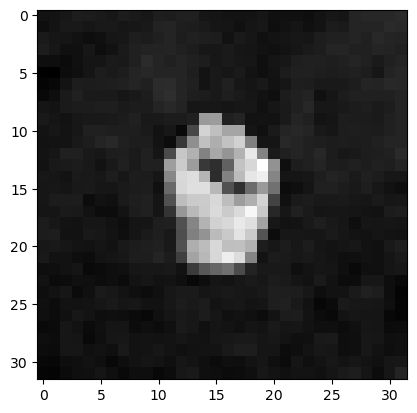

In [9]:
# train의 이미지 확인

plt.imshow(X_train[0], cmap='gray')
plt.show()

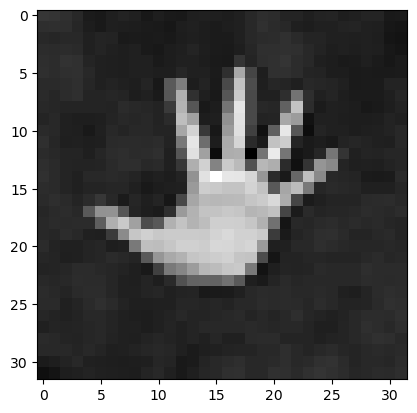

In [9]:
# test의 이미지 확인

plt.imshow(X_test[0], cmap='gray')
plt.show()

---
### numpy 배열로 변경

In [10]:
import numpy as np

In [11]:
1+1

2

In [12]:
# trainData 만들기

tempData = np.zeros(18000 * 32 * 32, dtype=np.int32).reshape(18000, 32, 32) 

i = 0
for image in X_train:
    img = np.array(image, dtype=np.int32)
    tempData[i,:,:] = img
    i += 1

X_train = tempData.copy()

In [13]:
# testData 만들기

tempData = np.zeros(3600 * 32 * 32, dtype=np.int32).reshape(3600, 32, 32) 

i = 0
for image in X_test:
    img = np.array(image, dtype=np.int32)
    tempData[i,:,:] = img
    i += 1

X_test = tempData.copy()

In [14]:
# 배열 크기 확인

print(X_train.shape, X_test.shape)

(18000, 32, 32) (3600, 32, 32)


---
### Label을 one hot encoding으로 변경하기

In [15]:
# one hot encoding data 준비

label_to_int={
    '0R' : 0,
    '1R' : 1,
    '2R' : 2,
    '3R' : 3,
    '4R' : 4,
    '5R' : 5,
    '0L' : 6,
    '1L' : 7,
    '2L' : 8,
    '3L' : 9,
    '4L' : 10,
    '5L' : 11
}

In [16]:
# 숫자로 변경하기

temp = []
for label in y_train:
    temp.append(label_to_int[label])
y_train = temp.copy()

temp = []
for label in y_test:
    temp.append(label_to_int[label])
y_test = temp.copy()

In [17]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [18]:
y_train[:5]

array([ 6,  6,  8,  6, 11])

In [19]:
from tensorflow import keras

---
### 정규화 하기

In [20]:
X_train = X_train.reshape(-1, 32, 32, 1) / 255.0
X_test = X_test.reshape(-1, 32, 32, 1) / 255.0

---
### train과 val data 분리하기

In [21]:
from sklearn.model_selection import train_test_split

trainData, valData, trainTargetData, valTargetData = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [22]:
# 크기 확인하기

print(trainData.shape)
print(valData.shape)
print(trainTargetData.shape)
print(valTargetData.shape)

(14400, 32, 32, 1)
(3600, 32, 32, 1)
(14400,)
(3600,)


---
# CNN만들기

In [23]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,1)))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(12, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,212 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,728 (1.64 MB)

 Trainable params: 429,728 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('../Data/cnn/best-cnn-fingers.keras')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(trainData, trainTargetData, epochs=20,
                    validation_data=(valData, valTargetData),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6597 - loss: 1.0355 - val_accuracy: 0.9975 - val_loss: 0.0178
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9860 - loss: 0.0507 - val_accuracy: 0.9997 - val_loss: 0.0019
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9950 - loss: 0.0183 - val_accuracy: 0.9981 - val_loss: 0.0045
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9945 - loss: 0.0155 - val_accuracy: 1.0000 - val_loss: 2.0300e-04
Epoch 5/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9964 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 2.3860e-04
Epoch 6/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9956 - loss: 0.0142 - val_accuracy: 1.0000 - val_loss: 8.1529e-05
Epoch 7/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9977 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 2.1598e-05
Epoch 8/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9982 - loss: 0

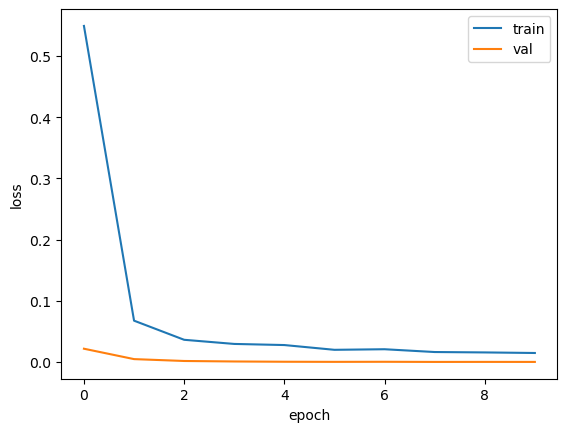

In [25]:
# 시각화 해보기

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

---
### 평가와 예측

In [26]:
# 검증 데이터 

model.evaluate(valData, valTargetData)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.5890e-05


[2.5963214284274727e-05, 1.0]

In [27]:
# Test 데이터

model.evaluate(X_test, y_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.6145e-04


[9.763245179783553e-05, 1.0]